In [1]:
import os
import sys
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import loadmat
from matplotlib.ticker import MultipleLocator
import nibabel as nib
import pickle

os.chdir('/home/rfpred')
sys.path.append('/home/rfpred')
sys.path.append('/home/rfpred/envs/rfenv/lib/python3.11/site-packages/')
sys.path.append('/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdcode')

print(sys.path)
%pwd

['/home/rfpred/notebooks', '/home/rfpred/envs/rfenv/lib/python311.zip', '/home/rfpred/envs/rfenv/lib/python3.11', '/home/rfpred/envs/rfenv/lib/python3.11/lib-dynload', '', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages', '/home/rfpred', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdcode']


'/home/rfpred'

In [10]:
from funcs.imgproc import get_imgs_designmx, rms_all, feature_df, show_stim, get_rms_contrast, get_rms_contrast_lab, get_contrast_df, get_img_prf, get_visfeature_dict
from funcs.rf_tools import get_mask, css_gaussian_cut, make_circle_mask, make_visrois_dict, write_prf_dict
from funcs.utility import print_dict_structure, print_large, get_zscore, hypotheses_plot, multiple_regression
from funcs.analyses import multivariate_regression, regression_dict_multivariate, plot_roi_beta_distribution, get_hrf_dict
from funcs.utility import numpy2coords, coords2numpy, filter_array_by_size, find_common_rows
# from funcs.viscontrasts import lgn_statistics
from notebooks.alien_nbs.lgnpy.lgnpy.CEandSC import lgn_statistics

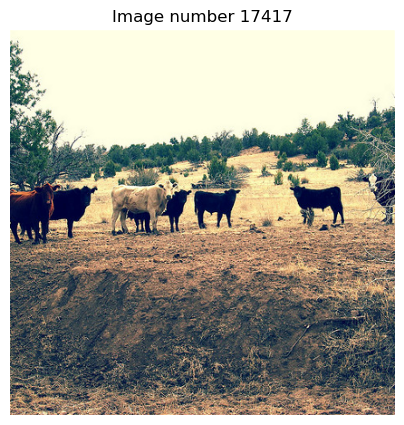

In [5]:
img = show_stim(small = 'y')

In [29]:
import glob
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

image_files=glob.glob('./notebooks/alien_nbs/selected_imgs/img*.jpg')
mask=Image.open('./notebooks/alien_nbs/selected_imgs/mask.png')
image_files.sort()

In [17]:
import imp
import yaml

import cv2
import notebooks.alien_nbs.lgnpy.lgnpy.CEandSC.lgn_statistics
imp.reload(notebooks.alien_nbs.lgnpy.lgnpy.CEandSC.lgn_statistics)
from notebooks.alien_nbs.lgnpy.lgnpy.CEandSC.lgn_statistics import lgn_statistics, loadmat

# compute dotpix
img_ix=1
meter_per_pixel=0.6773/2560
dot_pitch=(3 * meter_per_pixel / 2)*1.5 # dot pitch in meter (times 1.5 because we upscale the image)

config_path = './notebooks/alien_nbs/lgnpy/lgnpy/CEandSC/default_config.yml'
with open(config_path, 'r') as f:
    config = yaml.load(f, Loader=yaml.UnsafeLoader)
config['viewing_dist']=0.46
config['dot_pitch']= dot_pitch

In [21]:
import time
import pandas as pd
# threshold_lgn = loadmat(filepath='/content/lgnpy/ThresholdLGN.mat')['ThresholdLGN']
threshold_lgn = loadmat(filepath='./notebooks/alien_nbs/lgnpy/ThresholdLGN.mat')['ThresholdLGN']

Could not load mat file with mat73 - trying to load with scipy.io.loadmat!


In [30]:


ce, sc, beta, gamma = lgn_statistics(im=image_files[img_ix], file_name='noname.tiff',
                                        config=config, force_recompute=True, cache=False,
                                        home_path='./notebooks/alien_nbs/',
                                        threshold_lgn=threshold_lgn)



Computing LGN statistics for noname.tiff


/home/rfpred/notebooks/alien_nbs/lgnpy/lgnpy/CEandSC/lgn_statistics.py:523: RuntimeWarning: invalid value encountered in scalar divide
  sc[1,0,0] = np.mean(magnitude) / np.std(magnitude)
/home/rfpred/notebooks/alien_nbs/lgnpy/lgnpy/CEandSC/lgn_statistics.py:525: RuntimeWarning: invalid value encountered in scalar divide
  sc[2,0,0] = np.mean(magnitude) / np.std(magnitude)


In [3]:
n_subjects = len(os.listdir('/home/rfpred/data/natural-scenes-dataset/nsddata/ppdata'))
vismask_dict = make_visrois_dict(vox_count = 'y', bin_check = 'n', n_subjects=n_subjects)
prf_dict = write_prf_dict(binary_masks = vismask_dict)

Subject 1
V1_mask
Non-zero voxels in V1_mask: 7887
V2_mask
Non-zero voxels in V2_mask: 8296
V3_mask
Non-zero voxels in V3_mask: 7022
V4_mask
Non-zero voxels in V4_mask: 3976
Subject 2
V1_mask
Non-zero voxels in V1_mask: 6476
V2_mask
Non-zero voxels in V2_mask: 6376
V3_mask
Non-zero voxels in V3_mask: 6236
V4_mask
Non-zero voxels in V4_mask: 2887
Subject 3
V1_mask
Non-zero voxels in V1_mask: 7358
V2_mask
Non-zero voxels in V2_mask: 6721
V3_mask
Non-zero voxels in V3_mask: 5316
V4_mask
Non-zero voxels in V4_mask: 2486
Subject 4
V1_mask
Non-zero voxels in V1_mask: 5119
V2_mask
Non-zero voxels in V2_mask: 5088
V3_mask
Non-zero voxels in V3_mask: 4669
V4_mask
Non-zero voxels in V4_mask: 2790
Subject 5
V1_mask
Non-zero voxels in V1_mask: 6502
V2_mask
Non-zero voxels in V2_mask: 6309
V3_mask
Non-zero voxels in V3_mask: 5383
V4_mask
Non-zero voxels in V4_mask: 3184
Subject 6
V1_mask
Non-zero voxels in V1_mask: 6479
V2_mask
Non-zero voxels in V2_mask: 6905
V3_mask
Non-zero voxels in V3_mask: 71

In [4]:
# Load in the RMS contrast values for each image, in and out inner circle
all_rms = pd.read_pickle('all_rms_lab_df')
all_irrelevant_rms = pd.read_pickle('all_rms_irrelevant_df.pkl')

In [5]:
# # Load in the design matrix
# dmx = get_imgs_designmx()

# # Subject specific object with the correct sequence of RMS contrast values per image.
# rms_subj01 = feature_df(subject = 'subj01', feature = 'rms', feat_per_img = all_rms, designmx = dmx) 
# rms_irrelevant_subj01 = feature_df(subject = 'subj01', feature = 'rms', feat_per_img = all_irrelevant_rms, designmx = dmx)
# # Write loop for all subjects

# # Standardize the root mean square values by turning them into z-scores
# rms_subj01_z = get_zscore(rms_subj01['rms'], print_ars = 'n')

# # Add the z-scored RMS contrast values to the dataframe
# if rms_subj01.shape[1] == 2:    
#     rms_subj01.insert(2,'rms_z', rms_subj01_z)

# print(rms_subj01)

# print(rms_subj01)
# print(rms_irrelevant_subj01)


In [6]:
# # Standardize the root mean square values by turning them into z-scores
# rms_subj01_z = get_zscore(rms_subj01['rms'], print_ars = 'n')

# # Add the z-scored RMS contrast values to the dataframe
# if rms_subj01.shape[1] == 2:    
#     rms_subj01.insert(2,'rms_z', rms_subj01_z)

# print(rms_subj01)

In [7]:
def get_visfeature_dict(subjects, all_rms, all_irrelevant_rms, dmx):
    results = {}
    for subject in subjects:
        # Subject specific object with the correct sequence of RMS contrast values per image.
        rms = feature_df(subject=subject, feature='rms', feat_per_img=all_rms, designmx=dmx)
        rms_irrelevant = feature_df(subject=subject, feature='rms', feat_per_img=all_irrelevant_rms, designmx=dmx)

        # Standardize the root mean square values by turning them into z-scores
        rms_z = get_zscore(rms['rms'], print_ars='n')
        rms_irrelevant_z = get_zscore(rms_irrelevant['rms'], print_ars='n')

        # Add the z-scored RMS contrast values to the dataframe
        if rms.shape[1] == 2:
            rms.insert(2, 'rms_z', rms_z)
        if rms_irrelevant.shape[1] == 2:
            rms_irrelevant.insert(2, 'rms_z', rms_irrelevant_z)

        # Store the dataframes in the results dictionary
        results[subject] = {'rms': rms, 'rms_irrelevant': rms_irrelevant}

    return results

# Usage:
subjects = ['subj01', 'subj02', 'subj03', 'subj04', 'subj05', 'subj06', 'subj07', 'subj08']  # replace with your actual subjects
dmx = get_imgs_designmx()
visfeats = get_visfeature_dict(subjects, all_rms, all_irrelevant_rms, dmx)

### Okay this is super nice, now I need to first run a regression with the irrleevant RMS values, then I'm going to have to look at a larger central patch, so back to the pRF selection table, and then I'll have to figure out how to get SC and CE, also make everything more streamlined.

In [9]:
visfeats['subj05']

{'rms':        img_no        rms     rms_z
 0       46002  25.471033 -0.058404
 1        5736  41.151361  1.221880
 2        9203  35.636389  0.771588
 3       33362  21.846228 -0.354365
 4       64486  27.876221  0.137978
 ...       ...        ...       ...
 29995   46528  29.771790  0.292749
 29996   50683  30.991426  0.392331
 29997   44062  25.312996 -0.071307
 29998   53237  22.160278 -0.328723
 29999   54912  20.125339 -0.494874
 
 [30000 rows x 3 columns],
 'rms_irrelevant':        img_no        rms     rms_z
 0       46002  43.184334  2.276567
 1        5736  34.911203  1.561635
 2        9203  43.111651  2.270286
 3       33362   7.339469 -0.821010
 4       64486  12.357728 -0.387351
 ...       ...        ...       ...
 29995   46528  17.206866  0.031693
 29996   50683  22.388956  0.479510
 29997   44062  33.999139  1.482818
 29998   53237  30.799038  1.206277
 29999   54912  17.586175  0.064472
 
 [30000 rows x 3 columns]}

In [10]:
# Load in the saved masks for selected voxels that have their prf inside the inner patch.
with open('./data/custom_files/subj01/prf_mask_center_strict.pkl', 'rb') as fp:
    prf_mask_center_strict = pickle.load(fp)
    
    
with open('./data/custom_files/subj01/prf_mask_central_loose.pkl', 'rb') as fp:
    prf_mask_central_loose = pickle.load(fp) 
    

# Load in the saved file
with open('./data/custom_files/subj01/prf_mask_periphery_strict.pkl', 'rb') as fp:
   prf_mask_periphery_strict = pickle.load(fp)


# Load in the saved file
with open('./data/custom_files/subj01/new_prf_mask_central_strict.pkl', 'rb') as fp:
   new_central_mask = pickle.load(fp)

In [12]:
from multiprocessing import Pool

# These two functions are coupled to run the feature computations in parallel.
# This saves a lot of time. Should be combined with the feature_df function to assign
# the values to the corresponding trials.
def rms_single(args, ecc_max = 1, loc = 'center'):
    i, start, n, loc = args
    dim = show_stim(hide = 'y')[0].shape[0]
    radius = ecc_max * (dim / 8.4)

    if loc == 'center':
        x = y = (dim + 1)/2
    elif loc == 'irrelevant_patch':
        x = y = radius + 10
        
    mask_w_in = css_gaussian_cut(dim, x, y, radius)
    rf_mask_in = make_circle_mask(dim, x, y, radius, fill = 'y', margin_width = 0)
    ar_in = show_stim(img_no = i, hide = 'y')[0]  
    
    if i % 100 == 0:
        print(f"Processing image number: {i} out of {n + start}")
    return get_rms_contrast_lab(ar_in, mask_w_in, rf_mask_in, normalise = True, plot = 'n')


def rms_all(start, n, ecc_max = 1, loc = 'center'):
    img_vec = list(range(start, start + n))

    # Create a pool of worker processes
    with Pool() as p:
        rms_vec = p.map(rms_single, [(i, start, n, loc) for i in img_vec])

    rms_dict = pd.DataFrame({
        'rms': rms_vec
    })

    rms_dict = rms_dict.set_index(np.array(img_vec))
    return rms_dict


In [ ]:
rms_test = rms_all(start = 72998, n = 2)
rms_test

The peripheral RMS within-voxel check by looking at both the RMS contrast value in the central patch, and a RMS contrast value outside of the patch of equal size to the central one.

In [40]:
# rms_irrelevant = rms_all(start = 0, n = 10000, loc = 'irrelevant_patch')
# rms_irrelevant10k_50k = rms_all(start = 10000, n = 50000, loc = 'irrelevant_patch')
# rms_irrelevant60k_72k = rms_all(start = 60000, n = 13000, loc = 'irrelevant_patch')


In [46]:
# rms_irrelevant.to_pickle('rms_irrelevant0_10k.pkl')
# rms_irrelevant10k_50k.to_pickle('rms_irrelevant10k_50k.pkl')
# rms_irrelevant60k_72k.to_pickle('rms_irrelevant60k_72k.pkl')

In [52]:
all_rms_irrelevant = pd.concat(([rms_irrelevant, rms_irrelevant10k_50k, rms_irrelevant60k_72k]))

# Standardize the root mean square values by turning them into z-scores
rms_irrelevant_z = get_zscore(all_rms_irrelevant['rms'], print_ars = 'n')
all_rms_irrelevant['rms_z'] = rms_irrelevant_z

# Save the dataframe
all_rms_irrelevant.to_pickle('all_rms_irrelevant_df.pkl')

In [ ]:
# Standardize the root mean square values by turning them into z-scores
# rms_irrelevant_z = get_zscore(all_rms_irrelevant['rms'], print_ars = 'n')
# all_rms_irrelevant['rms_z'] = rms_irrelevant_z

In [53]:
all_rms_irrelevant = pd.read_pickle('all_rms_irrelevant_df.pkl')
print(all_rms_irrelevant)

             rms     rms_z
0       1.343889 -1.350403
1       2.371709 -1.261350
2       5.027124 -1.031278
3      18.204229  0.110421
4      14.664938 -0.196233
...          ...       ...
72995  21.163875  0.366852
72996   5.707909 -0.972293
72997  20.651257  0.322438
72998   4.416179 -1.084212
72999   7.660159 -0.803145

[73000 rows x 2 columns]


In [50]:
print(all_rms_irrelevant)

             rms     rms_z
0       1.343889 -1.350403
1       2.371709 -1.261350
2       5.027124 -1.031278
3      18.204229  0.110421
4      14.664938 -0.196233
...          ...       ...
72995  21.163875  0.366852
72996   5.707909 -0.972293
72997  20.651257  0.322438
72998   4.416179 -1.084212
72999   7.660159 -0.803145

[73000 rows x 2 columns]
